# K-Nearest Neighbors Modeling

In [1]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
#from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, roc_auc_score,\
recall_score, precision_score, average_precision_score, f1_score, classification_report,\
accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

## Read in the data

In [2]:
# read std data
df = pd.read_csv("hotel_bookings_dummy.csv")
df.head()

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,2,2015,7,0,0,0,3,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,2,2015,7,0,0,0,4,0,1,1,...,0,1,0,0,0,0,0,0,0,0
2,1,2015,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,2015,7,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,2,2015,7,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# Number of features
df.shape

(119388, 43)

## Splitting train and test

In [4]:
# get train indexes
train_ind = pd.read_csv("train_index.csv")

# split train
train = df.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)

# Split test 
test = df.iloc[df.index.difference(train_ind.Train_Index),:]

In [5]:
train.head(3)

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,2,2017,4,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,2016,5,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,2,2017,8,1,1,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [6]:
# Scale numeric columns 
scaler = StandardScaler()
scaler.fit(train.drop("is_canceled", axis = 1))

# Scale train data
xtrain = scaler.transform(train.drop("is_canceled", axis = 1))
ytrain = train.is_canceled

# Scale test data with train scaler 
xtest = scaler.transform(test.drop("is_canceled", axis = 1))
ytest = test.is_canceled

# Give everyone a header
dftrain = pd.DataFrame(xtrain)
dftrain.columns = train.drop("is_canceled", axis = 1).columns

In [7]:
dftrain.head(5)

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,0.255102,1.194999,-0.827079,-0.079146,0.397621,-0.246093,-0.339409,-0.259137,-0.827397,-2.645989,...,-0.214975,-0.343744,-0.445215,-0.506124,1.056154,-0.004576,-0.08367,2.698034,-0.313399,-0.098078
1,-1.514583,-0.220671,-0.503055,-0.079146,-2.514960,4.063508,-0.339409,-0.259137,1.208609,-2.645989,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
2,0.255102,1.194999,0.469018,10.108578,0.397621,-0.246093,1.200680,2.254616,-0.827397,0.377931,...,-0.214975,-0.343744,-0.445215,-0.506124,1.056154,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
3,0.255102,-0.220671,-0.503055,-0.079146,-2.514960,-0.246093,-0.339409,-0.259137,1.208609,0.377931,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078
4,-1.514583,1.194999,-1.475128,-0.079146,-2.514960,-0.246093,-0.339409,-0.259137,1.208609,0.377931,...,-0.214975,2.909140,-0.445215,-0.506124,-0.946831,-0.004576,-0.08367,-0.370640,-0.313399,-0.098078


## Code to fit a K-NN Model using sklearn

In [82]:
# Define a function the does a grid search to find the best parameter that gives the best score
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    params = np.array(range(param_range[0],param_range[1]+1))
    #params = np.random.uniform(param_range[0],param_range[1],10)
    #params = np.array([int(i) for i in params])
    params = np.sort(params)
    # Reference link : https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f
    kf = KFold(n_splits=folds)

    x_train = pd.DataFrame(x_train)
    y_train = pd.DataFrame(y_train)

    TRAIN_SCORES = []
    TEST_SCORES  = [] 
    #TRAIN_F1 = []
    #TEST_F1 = []
    
    for p in params:

        training_scores = []
        crossval_scores = []
        #training_f1 = []
        #crossval_f1 = []
        classifier.n_neighbors = int(p)

        for i in range(folds):
            result = next(kf.split(x_train),None)
            x_training = x_train.iloc[result[0]]
            x_cv = x_train.iloc[result[1]]

            y_training = y_train.iloc[result[0]]
            y_cv = y_train.iloc[result[1]]

            model = classifier.fit(x_training,y_training)
            training_scores.append(model.score(x_training,y_training))
            crossval_scores.append(model.score(x_cv,y_cv))
            #training_f1.append(model.f1)
    
        TRAIN_SCORES.append(np.mean(training_scores))
        TEST_SCORES.append(np.mean(crossval_scores))
    
    return(TRAIN_SCORES , TEST_SCORES)

In [87]:
import warnings
warnings.filterwarnings('ignore')

## For k = 1-40

In [ ]:
CV_score = []

In [92]:
# Use CV to find the K that optimizes accuracy
# It is too computationally intensive to do 10-fold validation, so I did 5.
classifier = KNeighborsClassifier()
X_train = pd.DataFrame(xtrain)
y_train = pd.DataFrame(ytrain)
train_score , cv_score = RandomSearchCV(X_train,y_train,classifier,(1,40),5)

print("The traning accuracy is: ", train_score)
print("The cross-validation accuracy is: ", cv_score)

The traning accuracy is:  [0.9936001465815097, 0.9251518165637107, 0.91989058737305, 0.9029290126688305, 0.8998665061250131, 0.8902863574494816, 0.8888205423515864, 0.8838995916657941, 0.8819364464453983, 0.8790440791540153, 0.8770809339336194, 0.8765966914459218, 0.8743194429902628, 0.8728405402575646, 0.8717804418385511, 0.8705763794367082, 0.8693723170348655, 0.8682075175374306, 0.8677101874149302, 0.8669249293267722, 0.8656816040205214, 0.8646869437755209, 0.8649748717411789, 0.8635352319128888, 0.8632603915820333, 0.8624620458590723, 0.8621479426238089, 0.8606428646215056, 0.8601193592294001, 0.8595565909328865, 0.8594126269500576, 0.8588629462883468, 0.858457229609465, 0.857554182808083, 0.8573971311904514, 0.8567165741807139, 0.8562061564234111, 0.8555386870484766, 0.854295361742226, 0.8538765574285415]
The cross-validation accuracy is:  [0.8502852955033241, 0.8521698162592262, 0.8542637282102288, 0.857875726325708, 0.8569334659477569, 0.8588703345024342, 0.8560435533685808, 0.8

In [94]:
from matplotlib import pyplot as plt

In [109]:
cv_result = pd.DataFrame({'k':ks, 'cv_score':cv_score, 'train_score':train_score})
cv_result.head(10)

,k,cv_score,train_score
0,1,0.850285,0.993600
1,2,0.852170,0.925152
2,3,0.854264,0.919891
3,4,0.857876,0.902929
4,5,0.856933,0.899867
5,6,0.858870,0.890286
6,7,0.856044,0.888821
7,8,0.856776,0.883900
8,9,0.855520,0.881936
9,10,0.856096,0.879044


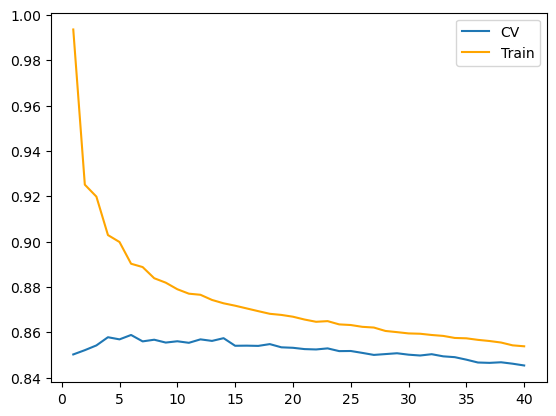

In [121]:
# Plot the accuracy score against K
plt.plot(cv_result['k'], cv_result['cv_score'], label = 'CV')
plt.plot(cv_result['k'], cv_result['train_score'], color = 'orange', label = 'Train')
plt.legend()
plt.show()

<AxesSubplot:xlabel='k'>

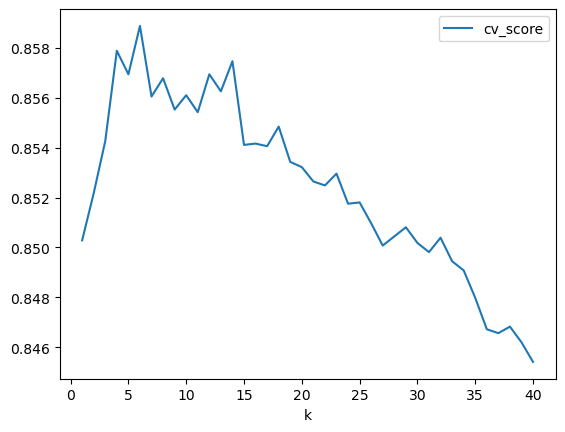

In [123]:
# Let's just look at the CV result
cv_result.plot(x = 'k', y = 'cv_score', kind = 'line')

The graph seems to suggest while the best accuracy is achieved at around k = 6, but seems like k = 14, or even k = 40 does fairly well. Perhaps I need to try higher numbers of k and see if there is a significant difference.

In [ ]:
# After I picked the best k, seems like I should fit the entire training

In [127]:
# Get test accuracy
neigh = KNeighborsClassifier(n_neighbors=14)
neigh.fit(xtrain, ytrain)
knn_accuracy = neigh.score(xtest,ytest)
knn_accuracy

0.8597394982619257

In [133]:
# Get test F-1 Score
yhat_test = neigh.predict(xtest)
f1_score(ytest, yhat_test)

0.8046437149719776

In [134]:
# Get test Confusion Matrix
confusion_matrix(ytest, yhat_test)

array([[13426,  1623],
       [ 1793,  7035]])